# Structured Matrices

We have seen how algebraic operations (`+`, `-`, `*`, `/`) are
well-defined for floating point numbers. Now we see how this allows us
to do (approximate) linear algebra operations on structured matrices. That is,
we consider the following structures:


1. _Dense_: this can be considered unstructured, where we need to store all entries in a
vector or matrix. Matrix multiplication reduces directly to standard algebraic operations.
2. _Triangular_: If a matrix is upper or lower triangular, we can immediately invert using
back-substitution. In practice we store a dense matrix and ignore the upper/lower entries.
3. _Banded_: If a matrix is zero apart from entries a fixed distance from  the diagonal it is
called banded and this allows for more efficient algorithms. We discuss diagonal, 
tridiagonal and bidiagonal
matrices.
4. _Orthogonal_: An orthogonal matrix $Q$ satisfies $Q^⊤ Q = I$, in other words, they are
very easy to invert. We discuss special cases includion permutations, rotations and reflections.


## 1. Dense vectors and matrices

A `Vector` of a primitive type (like `Int` or `Float64`) is stored
consecutively in memory. E.g. if we have `Vector{Int8}` of length
`n` then it is stored as `8n` bits (`n` bytes) in a row.
A  `Matrix` is stored consecutively in memory, going down column-by-
column. That is,

In [1]:
A = [1 2; 3 4; 5 6]

3×2 Matrix{Int64}:
 1  2
 3  4
 5  6

Is actually stored equivalently to a length `6` vector:

In [2]:
vec(A)

6-element Vector{Int64}:
 1
 3
 5
 2
 4
 6

Note that transposing `A` is done lazyily and so `A'`
stores the entries by row.


Matrix-vector multiplication works as expected:

In [3]:
x = [7; 8]
A*x

3-element Vector{Int64}:
 23
 53
 83

It is easy to implement such an algorithm:

In [4]:
c = zeros(Int, 3)
for j = 1:size(A,2), k = 1:size(A,1)
    c[k] += A[k, j] * x[j]
end
c

3-element Vector{Int64}:
 23
 53
 83

**Remark (advanced)** 
This accesses the entries of `A` going down the column,
which happens to be faster than accessing by row.

Note matrix-multiplication is exact for integers, but
using modular arithemtic:

In [5]:
Int8[2^7-1 1] * Int8[1,1]

1-element Vector{Int8}:
 -128

Solving a linear system is done using `\`:

In [6]:
b = [9; 10; 11]
A \ b

2-element Vector{Float64}:
 -8.00000000000002
  8.500000000000016

Here we see that we needed to use floating point arithmetic,
but it is "accurate to 16-digits". 
The way solving a linear system works is we first write `A` as a
product of simpler matrices, e.g., a product of triangular matrices, 
as described in the next notes. 


## 2. Triangular matrices



### Inverting an upper triangular matrix

We now discuss why upper triangular matrices are easy to invert.  
Consider a simple 3x3 example, which can be solved with `\`:
 ```julia
 U = [1.0 2.0 3.0;
      0.0 3.0 4.0;
      0.0 0.0 5.0]

b = [5,6,7]

x = U \ b
 ```
 Behind the seens, `\` is doing back substitution. Here is a custom implementation:
 ```julia
 function backsubstitution(U,b)
    n = size(U,1)
    
    if length(b) != n
        error("The system is not compatible")
    end
        
    
    x = zeros(n)  # the solution vector
    for k = n:-1:1  # start with k=n, then k=n-1, ...
        r = b[k]  # dummy variable
        for j = k+1:n
            r -= U[k,j]*x[j] # equivalent to r = r-U[k,j]*x[j]
        end
        x[k] = r/U[k,k]
    end
    x
end
backsubstitution(U,b) - U\b  # close to zero, the algorithms differ slightly
 ```

`triu` takes the upper triangular of a matrix.  We can check the accuracy of `backsubstitution` on a 10 x 10 random upper triangular matrix.

In [7]:
U = triu(rand(10,10))
b = rand(10)

x = U\b
norm(backsubstitution(U,b)-x)

LoadError: UndefVarError: backsubstitution not defined

## 3. Banded matrices


### Diagonal

Diagonal matrices in Julia are represented by a vector:

In [8]:
x = [1,2,3]
D = Diagonal(x)

3×3 Diagonal{Int64, Vector{Int64}}:
 1  ⋅  ⋅
 ⋅  2  ⋅
 ⋅  ⋅  3

It is clear that they can multiply and efficiently in $O(n)$ operations.

### Bidiagonal

Sometimes its useful to not store zero entries of a matrix when a matrix has many zeros,
which we refer to as _sparse_. A simple but important case is a triangular matrix where only
two bands are nonzero, i.e.,

## 4. Orthogonal matrices

**Definition (orthogonal matrix)** A matrix is _orthogonal_ if its inverse is its transpose:

$$Q^⊤ Q = I$$

Orthogonal matrices have the important property that they preserve the 2-norm of vectors:
$$
\|Q\mathbf{v}\|^2 = (Q\mathbf{v})^⊤ Q \mathbf{v} = \mathbf{v}^⊤ Q^⊤ Q \mathbf{v} = \mathbf{v}^⊤  \mathbf{v} = \|\mathbf{v}\|^2
$$
Here we discuss three important cases: permutations, simple rotations and reflections.

### Permutation Matrices

Permutation matrices are matrices that represent the action of permuting the entries of a vector,
that is, matrix representations of the symmetric group $S_n$, acting on $ℝ^n$.
Recall every $σ \in S_n$ is a bisection between $\{1,2,\ldots,n\}$.
We can write a permutation $σ$ in _Cauchy notation_:
$$
\begin{pmatrix}
 1 & 2 & 3 & \cdots & n \cr
 σ_1 & σ_2 & σ_3 & \cdots & σ_n
 \end{pmatrix}
$$
where $\{σ_1,\ldots,σ_n\} = \{1,2,\ldots,n\}$ (that is, each integer appears precisely once).
We denote the _inverse permutation_ by $σ^{-1}$, which can be constructed by swapping the rows of
the Cauchy notation and reordering.

We can encode a permutation in vector $\mathbf σ = [σ_1,\ldots,σ_n]^⊤$. 
This induces an action on a vector (using indexing notation)
$$
𝐯[\mathbf σ] = \begin{pmatrix}v_{σ_1}\\ \vdots \\ v_{σ_n} \end{pmatrix}
$$


**Example (permutation of a vector)** 
Consider the permutation $σ$ given by
$$
\begin{pmatrix}
 1 & 2 & 3 & 4 & 5 \cr
 1 & 4 & 2 & 5 & 3
 \end{pmatrix}
$$
We can apply it to a vector of the first 5 letter:

In [9]:
σ = [1, 4, 2, 5, 3]
v = [6, 7, 8, 9, 10]
v[σ] # we permutate entries of v

5-element Vector{Int64}:
  6
  9
  7
 10
  8

Its inverse permutation $σ^{-1}$ has Cauchy notation coming from swapping the rows of
the Cauchy notation of $σ$ and sorting:
$$
\begin{pmatrix}
 1 & 4 & 2 & 5 & 3 \cr
 1 & 2 & 3 & 4 & 5
 \end{pmatrix} \rightarrow \begin{pmatrix}
 1 & 2 & 4 & 3 & 5 \cr
 1 & 3 & 2 & 5 & 4
 \end{pmatrix} 
$$
And indeed:

In [10]:
σ⁻¹ = [1,3,2,5,4] # note that ⁻¹ are just unicode characters in the variable name
v[σ][σ⁻¹] # permuting by σ and then σⁱ gets us back

5-element Vector{Int64}:
  6
  7
  9
  8
 10

Note that the operator
$$
P_σ(𝐯) = 𝐯[\mathbf σ]
$$
is linear in $𝐯$, therefore, we can identify it with a matrix whose action is:
$$
P_σ \begin{pmatrix} v_1\\ \vdots \\ v_n \end{pmatrix} = \begin{pmatrix}v_{σ_1} \\ \vdots \\ v_{σ_n}  \end{pmatrix}.
$$
The entries of this matrix are
$$
P_σ[k,j] = 𝐞_k^⊤ P_σ 𝐞_j = 𝐞_k^⊤ 𝐞_{σ^{-1}_j} = δ_{k,σ^{-1}_j} = δ_{σ_k,j}
$$
where $δ_{k,j}$ is the _Kronecker delta_:
$$
δ_{k,j} := \begin{cases} 1 & k = j \\
                        0 & \hbox{otherwise}
                        \end{cases}.
$$


This construction motivates the following definition:

**Definition (permutation matrix)** $P \in ℝ^{n × n}$ is a permutation matrix if it is equal to
the identity matrix with its rows permuted.

**Example (5×5 permutation matrix)**
We can construct the permutation representation for $σ$ as above as follows:

In [11]:
P = I(5)[σ,:]

5×5 SparseMatrixCSC{Bool, Int64} with 5 stored entries:
 1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅
 ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅  ⋅

And indeed, we see its action is as expected:

In [12]:
P * v

5-element Vector{Int64}:
  6
  9
  7
 10
  8

**Proposition (permutation matrix inverse)** 
Let $P_σ$ be a permutation matrix corresponding to the permutation $σ$. Then
$$
P_σ^⊤ = P_{σ^{-1}} = P_σ^{-1}
$$
That is, $P_σ$ is _orthogonal_:
$$
P_σ^⊤ P_σ = P_σ P_σ^⊤ = I.
$$

**Proof**

We prove orthogonality via:
$$
𝐞_k^⊤ P_σ^⊤ P_σ 𝐞_j = (P_σ 𝐞_k)^⊤ P_σ 𝐞_j = 𝐞_{σ^{-1}_k}^⊤ 𝐞_{σ^{-1}_j} = δ_{k,j}
$$
This shows $P_σ^⊤ P_σ = I$ and hence $P_σ^{-1} = P_σ^⊤$. 

∎


Permutation matrices are examples of sparse matrices that can be very easily inverted. 


### Simple rotations

In 2D we get some simple examples:
$$
\begin{pmatrix} 1 & 0 \cr 0 & 1\end{pmatrix}, \begin{pmatrix} 1 & 0 \cr 0 & -1\end{pmatrix}, \begin{pmatrix} 0 & 1 \cr 1 & 0\end{pmatrix}, \begin{pmatrix} \cos \theta & -\sin \theta \cr \sin \theta & \cos \theta \end{pmatrix}
$$

The last matrix is a rotation matrix.  We can visualize this using Plots.jl, seeing that the 2-norm is preserved:

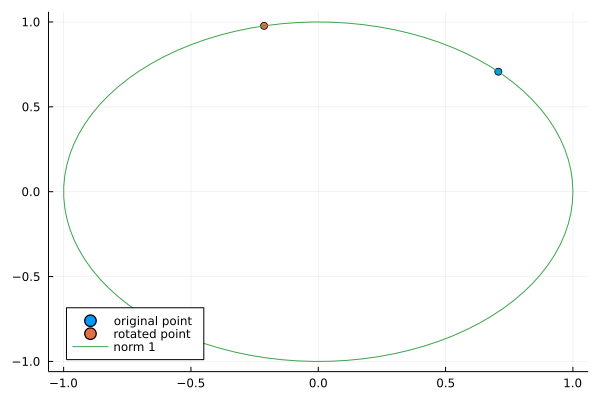

In [13]:
using Plots

θ = 1.     # rotation angle
Q = [cos(θ) -sin(θ);
    sin(θ) cos(θ)]    # rotation matrix

v = [1,1]/sqrt(2)      # point on the circle
Qv = Q*v               # rotated vector
x = Qv[1]     # x coordinate of the rotated vector
y = Qv[2]     # y coordinate of the rotated vector

scatter([v[1]], [v[2]]; label="original point", legend=:bottomleft)
scatter!([x], [y]; label="rotated point")

# now plot the circle
grid = range(0, 2π; length=100)       # plotting grid for the circle
plot!(cos.(grid), sin.(grid); label="norm 1")     # plot circle in red

On a computer, we don't know exactly where a point is: every point can have a small $\epsilon$ of error.  
Thus to understand the robustness of an algorithm, we need to understand what happens to balls of radius 
$\epsilon$ around where we think of the point.  
This can be used to demonstrate why rotations are preferred to lower triangular operations.

In the following, we design a function that plots a circle around a point `[a,b]` of size `ε`, both before and after a matrix `L` is applied.
Here we demonstrate that the effect of `L` is to stretch the circles: our error can be amplified:

In [14]:
using Plots
function plotmat(a,b,ε,L)
    t = range(0, 2π; length=100)
    x,y = (a+ε*cos(t),b+ε*sin(t))
    plot(x,y)

    Lx = zeros(length(x))
    Ly = zeros(length(x))

    for k=1:length(x)
        Lx[k],Ly[k] = L*[x[k],y[k]]
    end
    plot!(Lx,Ly)
end
a,b = [1.1, 1.2]

L = [1    0;
     -b/a 1]

ε = 0.1

plotmat(a, b, ε, L)

LoadError: MethodError: no method matching cos(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
[0mClosest candidates are:
[0m  cos([91m::T[39m) where T<:Union{Float32, Float64} at ~/Projects/julia-1.7/usr/share/julia/base/special/trig.jl:98
[0m  cos([91m::Hermitian{var"#s858", S} where {var"#s858"<:Complex, S<:(AbstractMatrix{<:var"#s858"})}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:761
[0m  cos([91m::Union{Hermitian{var"#s859", S}, Symmetric{var"#s859", S}} where {var"#s859"<:Real, S}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:757
[0m  ...

As `a` becomes small, this error amplification becomes greater: in the following, we go from 
knowing the true point with accuracy 0.1 to only knowing it with about accuracy 1:

In [15]:
a,b = [0.125,1.2]

L = [1    0;
     -b/a 1]

ε = 0.1

plotmat(a, b, ε, L)

LoadError: MethodError: no method matching cos(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
[0mClosest candidates are:
[0m  cos([91m::T[39m) where T<:Union{Float32, Float64} at ~/Projects/julia-1.7/usr/share/julia/base/special/trig.jl:98
[0m  cos([91m::Hermitian{var"#s858", S} where {var"#s858"<:Complex, S<:(AbstractMatrix{<:var"#s858"})}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:761
[0m  cos([91m::Union{Hermitian{var"#s859", S}, Symmetric{var"#s859", S}} where {var"#s859"<:Real, S}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:757
[0m  ...

Rotations perform much better: the circles are only rotated, and are not magnified at all:

In [16]:
a,b=[1.1,1.2]

θ=-atan(b,a)
Q=[cos(θ) -sin(θ);
    sin(θ) cos(θ)]

ε=0.1

plotmat(a,b,ε,Q)
plotmat(0,b,ε,Q)

plotmat(2a,b,ε,Q)
axis([-5,5,-5,5])

LoadError: MethodError: no method matching cos(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})
[0mClosest candidates are:
[0m  cos([91m::T[39m) where T<:Union{Float32, Float64} at ~/Projects/julia-1.7/usr/share/julia/base/special/trig.jl:98
[0m  cos([91m::Hermitian{var"#s858", S} where {var"#s858"<:Complex, S<:(AbstractMatrix{<:var"#s858"})}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:761
[0m  cos([91m::Union{Hermitian{var"#s859", S}, Symmetric{var"#s859", S}} where {var"#s859"<:Real, S}[39m) at ~/Projects/julia-1.7/usr/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetric.jl:757
[0m  ...

We can construct a simpler expression for `Q` as 
$$
{1 \over \sqrt{a^2 + b^2}}\begin{pmatrix}
 a & b \cr -b & a
\end{pmatrix}
$$

### Reflections

In addition to rotations, another type of orthognal matrix are reflections:

**Definition (reflection matrix)** 
Given a vector $𝐯$ satisfying $\|𝐯\|=1$, the reflection matrix is the orthogonal matrix as
$$
Q_𝐯 \triangleq I - 2 𝐯 𝐯^⊤
$$

These are reflections in the direction of $𝐯$. We can show this as follows:

**Proposition** $Q_𝐯$ satisfies:
1. Symmetry
2. Orthogonality
2. $𝐯$ is an eigenvector of $Q_𝐯$ with eigenvalue $-1$
4. It is a rank-1 perturbation of $I$
3. $\det Q_𝐯 = -1$


**Proof**

Property 1 follows immediately. Property 2 follows from
$$
Q_𝐯^⊤ Q_𝐯 = Q_𝐯^2 = I - 4 𝐯 𝐯^⊤ + 4 𝐯 𝐯^⊤ 𝐯 𝐯^⊤ = I
$$
Property 3 follows since
$$
Q_𝐯 𝐯 = -𝐯
$$
Property 4 follows since $𝐯 𝐯^⊤$ is a rank-1 matrix as all rows are linear combinations of each other.
To see property 5, note there is a dimension $n-1$ space $W$ orthogonal to $𝐯$.
For $\mathbf w \in W$ we have
$$
Q_𝐯 \mathbf w = \mathbf w
$$
In other words, $1$ is an eigenvalue with multiplicity $n-1$ and $-1$ is an eigenvalue with multiplicity 1,
and thus the product of the eigenvalues is $-1$.

∎